In [1]:
import os
import pandas as pd

In [2]:
import os
import pandas as pd

# Function to extract information from a single .fds file
def extract_fds_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Initialize variables
    chid = None
    tmpa = None
    has_floor_heating = False
    has_radiator = False
    supply_tmp_front = None  # Supply TMP_FRONT
    wall_tmp_front = None    # Wall TMP_FRONT

    # Extract CHID from the first line
    if len(lines) > 0:
        first_line = lines[0].strip()
        if "CHID" in first_line:
            chid = first_line.split("CHID =")[1].split("'")[1]

    # Extract TMPA from the second line
    if len(lines) > 1:
        second_line = lines[1].strip()
        if "TMPA" in second_line:
            try:
                # Extract TMPA value more flexibly
                tmpa = float(second_line.split("TMPA")[1].split("=")[1].split("/")[0].split(",")[0].strip())
            except (IndexError, ValueError):
                tmpa = None  # Handle cases where TMPA cannot be parsed

    # Check for keywords, Supply TMP_FRONT, and Wall TMP_FRONT in lines
    for line in lines:
        if "floor_heating" in line.lower():
            has_floor_heating = True
        if "radiator" in line.lower():
            has_radiator = True
        if line.strip().startswith("&SURF ID='supply"):
            # Extract Supply TMP_FRONT value
            try:
                supply_tmp_front = float(line.split("TMP_FRONT=")[1].split("/")[0].strip())
            except (IndexError, ValueError):
                supply_tmp_front = None
        if line.strip().startswith("&SURF ID='WALL "):
            # Extract Wall TMP_FRONT value
            try:
                wall_tmp_front = float(line.split("TMP_FRONT =")[1].split("/")[0].strip())
            except (IndexError, ValueError):
                wall_tmp_front = None

    return chid, tmpa, has_floor_heating, has_radiator, supply_tmp_front, wall_tmp_front

# Function to classify cases based on TMP_FRONT, Floor Heating, and Radiator
def classify_case(row):
    if row['Supply TMP_FRONT'] == 12:
        return "Cooling"
    elif row['Supply TMP_FRONT'] == 35 or row['Floor Heating'] or row['Radiator']:
        return "Heating"
    else:
        return "Ventilation"

# Function to determine the heating system type
def determine_heating_system(row):
    if row['Case Type'] == "Heating":
        if row['Floor Heating']:
            return "Floor Heating"
        elif row['Radiator']:
            return "Radiator"
        else:
            return "Forced Air"
    return None

# Main script to process all .fds files in a folder (including subfolders)
def process_fds_files(folder_path):
    data = []

    # Walk through the directory and its subdirectories
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith(".fds"):
                file_path = os.path.join(root, file_name)
                chid, tmpa, has_floor_heating, has_radiator, supply_tmp_front, wall_tmp_front = extract_fds_data(file_path)
                # Only add entries with a valid CHID
                if chid is not None:
                    data.append({
                        "CHID": chid,
                        "TMPA": tmpa,
                        "Floor Heating": has_floor_heating,
                        "Radiator": has_radiator,
                        "Supply TMP_FRONT": supply_tmp_front,
                        "Wall TMP_FRONT": wall_tmp_front
                    })
    
    # Create a DataFrame
    df = pd.DataFrame(data)

    # Add a new column for case classification
    df['Case Type'] = df.apply(classify_case, axis=1)

    # Add a column for Heating System
    df['Heating System'] = df.apply(determine_heating_system, axis=1)

    return df

# Specify the folder containing the .fds files
folder_path = r"out/validation fds"

# Process the files and generate the DataFrame
result_df = process_fds_files(folder_path)

# Display or save the DataFrame
print(result_df)
# Save to CSV if needed
result_df.to_csv("fds_data_summary_with_wall_tmp_front.csv", index=False)


      CHID  TMPA  Floor Heating  Radiator  Supply TMP_FRONT  Wall TMP_FRONT  \
0     1069  16.0           True     False              35.0       16.110291   
1     1855  25.0           True     False              25.0       25.574463   
2      797  18.0          False      True              18.0       17.776079   
3     6842  28.0          False     False              12.0       28.670119   
4     4729  25.0           True     False              25.0       24.322994   
...    ...   ...            ...       ...               ...             ...   
6995  4336  26.0           True     False              26.0       25.946603   
6996  1644  23.0          False     False              23.0       22.869763   
6997  3113  20.0          False      True              20.0       19.758448   
6998  6461  28.0          False     False              12.0       30.902196   
6999   986  19.0          False      True              19.0       19.000000   

        Case Type Heating System  
0         Heatin

In [3]:
import matplotlib.pyplot as plt

#Heat Flux Through Envelope
result_df["heat_flux"] = 8 * (result_df["TMPA"] - result_df["Wall TMP_FRONT"])

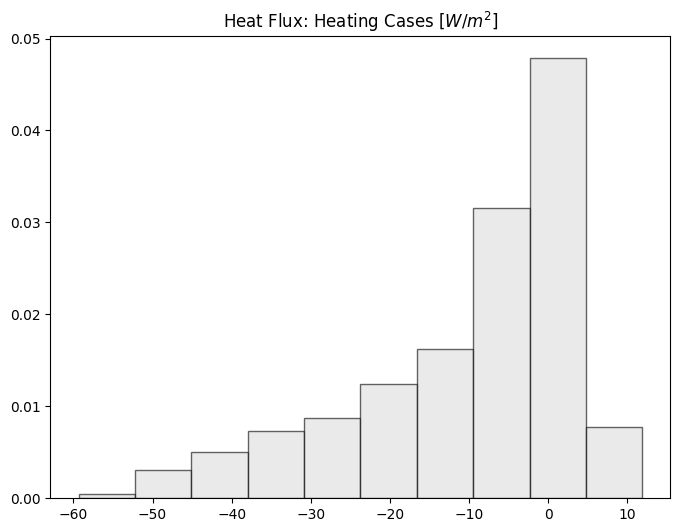

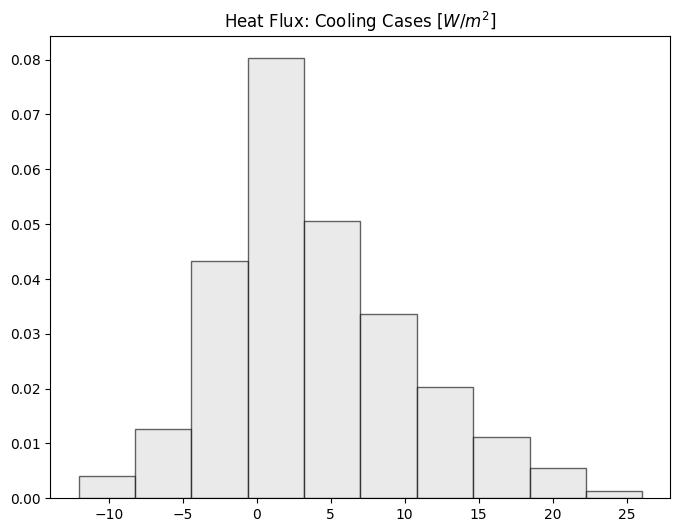

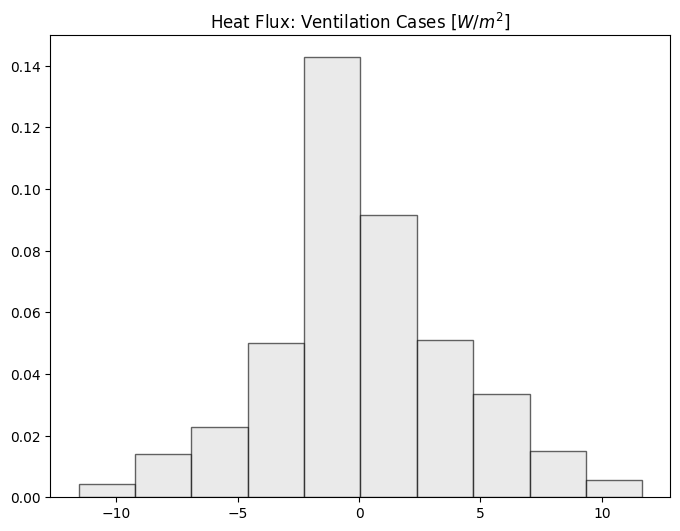

In [4]:
heatflux_heating = result_df[result_df["Case Type"] == 'Heating']["heat_flux"]
heatflux_cooling = result_df[result_df["Case Type"] == 'Cooling']["heat_flux"]
heatflux_vent = result_df[result_df["Case Type"] == 'Ventilation']["heat_flux"]

plt.figure(figsize=(8,6))
plt.title('Heat Flux: Heating Cases [$W/m^2$]')
plt.hist(-heatflux_heating,density=True,alpha=0.6,color='#DDDDDD',edgecolor='black')
plt.savefig('heatingflux.png',dpi=300)

plt.figure(figsize=(8,6))
plt.title('Heat Flux: Cooling Cases [$W/m^2$]')
plt.hist(-heatflux_cooling,density=True,alpha=0.6,color='#DDDDDD',edgecolor='black')
plt.savefig('coolingflux.png',dpi=300)

plt.figure(figsize=(8,6))
plt.title('Heat Flux: Ventilation Cases [$W/m^2$]')
plt.hist(-heatflux_vent,density=True,alpha=0.6,color='#DDDDDD',edgecolor='black')
plt.savefig('ventflux.png',dpi=300)

In [5]:
import os
import pandas as pd

# Function to extract information from a single .fds file
def extract_fds_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Initialize variables
    chid = None
    tmpa = None
    has_floor_heating = False
    has_radiator = False
    supply_tmp_front = None  # Supply TMP_FRONT
    wall_tmp_front = None    # Wall TMP_FRONT
    room_dimensions = None   # Room dimensions (x, y, z extents)

    # Extract CHID from the first line
    if len(lines) > 0:
        first_line = lines[0].strip()
        if "CHID" in first_line:
            chid = first_line.split("CHID =")[1].split("'")[1]

    # Extract TMPA from the second line
    if len(lines) > 1:
        second_line = lines[1].strip()
        if "TMPA" in second_line:
            try:
                # Extract TMPA value more flexibly
                tmpa = float(second_line.split("TMPA")[1].split("=")[1].split("/")[0].split(",")[0].strip())
            except (IndexError, ValueError):
                tmpa = None  # Handle cases where TMPA cannot be parsed

    # Check for keywords, Supply TMP_FRONT, Wall TMP_FRONT, and room dimensions in lines
    for line in lines:
        if "floor_heating" in line.lower():
            has_floor_heating = True
        if "radiator" in line.lower():
            has_radiator = True
        if line.strip().startswith("&SURF ID='supply"):
            # Extract Supply TMP_FRONT value
            try:
                supply_tmp_front = float(line.split("TMP_FRONT=")[1].split("/")[0].strip())
            except (IndexError, ValueError):
                supply_tmp_front = None
        if line.strip().startswith("&SURF ID='WALL"):
            # Extract Wall TMP_FRONT value
            try:
                wall_tmp_front = float(line.split("TMP_FRONT =")[1].split("/")[0].strip())
            except (IndexError, ValueError):
                wall_tmp_front = None
        if line.strip().startswith("&MESH XB"):
            # Extract room dimensions
            try:
                values = line.split("XB =")[1].split(",")[:6]  # Get the six values after XB =
                room_dimensions = (float(values[1]), float(values[3]), float(values[5]))  # Max x, y, z
            except (IndexError, ValueError):
                room_dimensions = None

    return chid, tmpa, has_floor_heating, has_radiator, supply_tmp_front, wall_tmp_front, room_dimensions

# Function to classify cases based on TMP_FRONT, Floor Heating, and Radiator
def classify_case(row):
    if row['Supply TMP_FRONT'] == 12:
        return "Cooling"
    elif row['Supply TMP_FRONT'] == 35 or row['Floor Heating'] or row['Radiator']:
        return "Heating"
    else:
        return "Ventilation"

# Function to determine the heating system type
def determine_heating_system(row):
    if row['Case Type'] == "Heating":
        if row['Floor Heating']:
            return "Floor Heating"
        elif row['Radiator']:
            return "Radiator"
        else:
            return "Forced Air"
    return None

# Main script to process all .fds files in a folder (including subfolders)
def process_fds_files(folder_path):
    data = []

    # Walk through the directory and its subdirectories
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith(".fds"):
                file_path = os.path.join(root, file_name)
                chid, tmpa, has_floor_heating, has_radiator, supply_tmp_front, wall_tmp_front, room_dimensions = extract_fds_data(file_path)
                # Only add entries with a valid CHID
                if chid is not None:
                    data.append({
                        "CHID": chid,
                        "TMPA": tmpa,
                        "Floor Heating": has_floor_heating,
                        "Radiator": has_radiator,
                        "Supply TMP_FRONT": supply_tmp_front,
                        "Wall TMP_FRONT": wall_tmp_front,
                        "Room Dimensions (x,y,z)": room_dimensions
                    })
    
    # Create a DataFrame
    df = pd.DataFrame(data)

    # Add a new column for case classification
    df['Case Type'] = df.apply(classify_case, axis=1)

    # Add a column for Heating System
    df['Heating System'] = df.apply(determine_heating_system, axis=1)

    return df

# Specify the folder containing the .fds files
folder_path = r"out/validation fds"

# Process the files and generate the DataFrame
result_df = process_fds_files(folder_path)

# Display or save the DataFrame
print(result_df)
# Save to CSV if needed
result_df.to_csv("fds_data_summary_with_room_dimensions.csv", index=False)


      CHID  TMPA  Floor Heating  Radiator  Supply TMP_FRONT  Wall TMP_FRONT  \
0     1069  16.0           True     False              35.0       16.110291   
1     1855  25.0           True     False              25.0       25.574463   
2      797  18.0          False      True              18.0       17.776079   
3     6842  28.0          False     False              12.0       28.670119   
4     4729  25.0           True     False              25.0       24.322994   
...    ...   ...            ...       ...               ...             ...   
6995  4336  26.0           True     False              26.0       25.946603   
6996  1644  23.0          False     False              23.0       22.869763   
6997  3113  20.0          False      True              20.0       19.758448   
6998  6461  28.0          False     False              12.0       30.902196   
6999   986  19.0          False      True              19.0       19.000000   

     Room Dimensions (x,y,z)    Case Type Heating S

In [10]:
import os
import pandas as pd

# Function to extract information from a single .fds file
def extract_fds_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Initialize variables
    chid = None
    tmpa = None
    has_floor_heating = False
    has_radiator = False
    supply_tmp_front = None  # Supply TMP_FRONT
    wall_tmp_front = None    # Wall TMP_FRONT
    room_dimensions = None   # Room dimensions (x, y, z extents)
    vent_type = None         # Vent type (e.g., Swirl, Louvered)
    ##New Variables
    radiator_coords = None #Radiator Coordinates
    inlet_coords = None #Inlet Coordinates
    exhaust_coords = None #Exhaust Coordinates
    computer_coords = None #Computer Coordinates
    obstacle_coords = None #Obstacle Coordinates
    occupant_coords = None #Occupant Coordinates
    inlet_velocity = None #Inlet Vent Speed

    # Extract CHID and Vent Type from the first line
    if len(lines) > 0:
        first_line = lines[0].strip()
        if "CHID" in first_line:
            chid = first_line.split("CHID =")[1].split("'")[1]
        if "Vent Type:" in first_line:
            try:
                vent_type = first_line.split("Vent Type:")[1].split(",")[0].strip("'")
            except IndexError:
                vent_type = None

    # Extract TMPA from the second line
    if len(lines) > 1:
        second_line = lines[1].strip()
        if "TMPA" in second_line:
            try:
                # Extract TMPA value more flexibly
                tmpa = float(second_line.split("TMPA")[1].split("=")[1].split("/")[0].split(",")[0].strip())
            except (IndexError, ValueError):
                tmpa = None  # Handle cases where TMPA cannot be parsed

    # Check for keywords, Supply TMP_FRONT, Wall TMP_FRONT, and room dimensions in lines
    for line in lines:
        if "floor_heating" in line.lower():
            has_floor_heating = True
        if "radiator" in line.lower():
            has_radiator = True
        if line.strip().startswith("&SURF ID='supply"):
            # Extract Supply TMP_FRONT value
            try:
                supply_tmp_front = float(line.split("TMP_FRONT=")[1].split("/")[0].strip())
            except (IndexError, ValueError):
                supply_tmp_front = None
        if line.strip().startswith("&SURF ID='WALL"):
            # Extract Wall TMP_FRONT value
            try:
                wall_tmp_front = float(line.split("TMP_FRONT =")[1].split("/")[0].strip())
            except (IndexError, ValueError):
                wall_tmp_front = None
        if line.strip().startswith("&MESH XB"):
            # Extract room dimensions
            try:
                values = line.split("XB =")[1].split(",")[:6]  # Get the six values after XB =
                room_dimensions = (float(values[1]), float(values[3]), float(values[5]))  # Max x, y, z
            except (IndexError, ValueError):
                room_dimensions = None

    return chid, vent_type, tmpa, has_floor_heating, has_radiator, supply_tmp_front, wall_tmp_front, room_dimensions

# Function to classify cases based on TMP_FRONT, Floor Heating, and Radiator
def classify_case(row):
    if row['Supply TMP_FRONT'] == 12:
        return "Cooling"
    elif row['Supply TMP_FRONT'] == 35 or row['Floor Heating'] or row['Radiator']:
        return "Heating"
    else:
        return "Ventilation"

# Function to determine the heating system type
def determine_heating_system(row):
    if row['Case Type'] == "Heating":
        if row['Floor Heating']:
            return "Floor Heating"
        elif row['Radiator']:
            return "Radiator"
        else:
            return "Forced Air"
    return None

# Main script to process all .fds files in a folder (including subfolders)
def process_fds_files(folder_path):
    data = []

    # Walk through the directory and its subdirectories
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith(".fds"):
                file_path = os.path.join(root, file_name)
                chid, vent_type, tmpa, has_floor_heating, has_radiator, supply_tmp_front, wall_tmp_front, room_dimensions = extract_fds_data(file_path)
                # Only add entries with a valid CHID
                if chid is not None:
                    data.append({
                        "CHID": chid,
                        "Vent Type": vent_type,
                        "TMPA": tmpa,
                        "Floor Heating": has_floor_heating,
                        "Radiator": has_radiator,
                        "Supply TMP_FRONT": supply_tmp_front,
                        "Wall TMP_FRONT": wall_tmp_front,
                        "Room Dimensions (x,y,z)": room_dimensions
                    })
    
    # Create a DataFrame
    df = pd.DataFrame(data)

    # Add a new column for case classification
    df['Case Type'] = df.apply(classify_case, axis=1)

    # Add a column for Heating System
    df['Heating System'] = df.apply(determine_heating_system, axis=1)

    return df

# Specify the folder containing the .fds files
folder_path = r"out/validation fds"

# Process the files and generate the DataFrame
result_df = process_fds_files(folder_path)

# Display or save the DataFrame
print(result_df)
# Save to CSV if needed
result_df.to_csv("fds_data_summary_with_vent_type.csv", index=False)


      CHID        Vent Type  TMPA  Floor Heating  Radiator  Supply TMP_FRONT  \
0     1069            Swirl  16.0           True     False              35.0   
1     1855  Louvered Square  25.0           True     False              25.0   
2      797            Swirl  18.0          False      True              18.0   
3     6842  Louvered Square  28.0          False     False              12.0   
4     4729         Louvered  25.0           True     False              25.0   
...    ...              ...   ...            ...       ...               ...   
6995  4336            Swirl  26.0           True     False              26.0   
6996  1644            Swirl  23.0          False     False              23.0   
6997  3113            Swirl  20.0          False      True              20.0   
6998  6461         Louvered  28.0          False     False              12.0   
6999   986            Swirl  19.0          False      True              19.0   

      Wall TMP_FRONT Room Dimensions (x

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:19: SyntaxWarning: invalid escape sequence '\m'
/var/folders/7y/d40s_s1129b861kk9hxxws140000gn/T/ipykernel_1445/629665082.py:7: SyntaxWarning: invalid escape sequence '\m'
  plt.hist(xdims,density=True,alpha=0.6,color='#DDDDDD',edgecolor='black',bins=35,label='$\mathcal{N} \sim (\mu=5,\sigma=0.5)$')
/var/folders/7y/d40s_s1129b861kk9hxxws140000gn/T/ipykernel_1445/629665082.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.hist(ydims,density=True,alpha=0.6,color='#DDDDDD',edgecolor='black',bins=33,label='$\mathcal{N} \sim (\mu=5,\sigma=0.5)$')
/var/folders/7y/d40s_s1129b861kk9hxxws140000gn/T/ipykernel_1445/629665082.py:19: SyntaxWarning: invalid escape sequence '\m'
  plt.hist(zdims,density=True,alpha=0.6,color='#DDDDDD',edgecolo

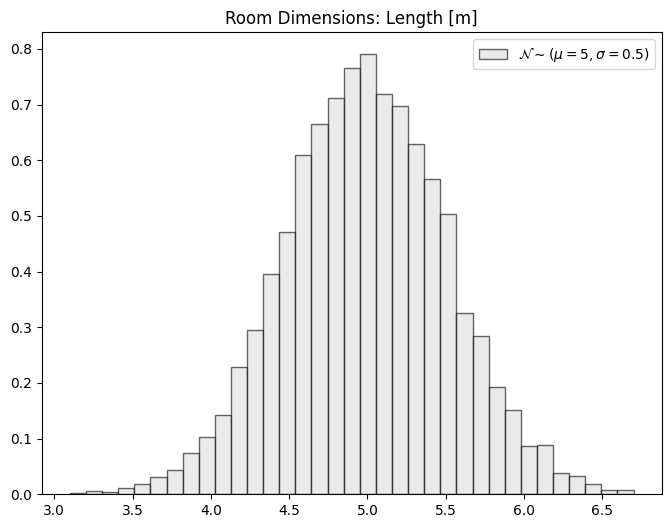

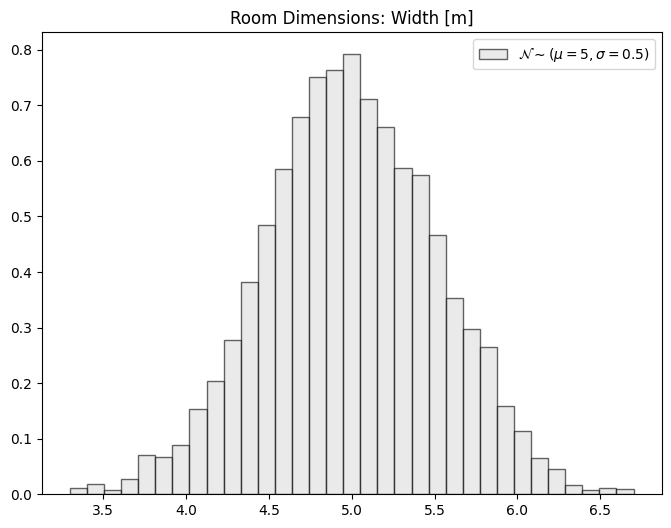

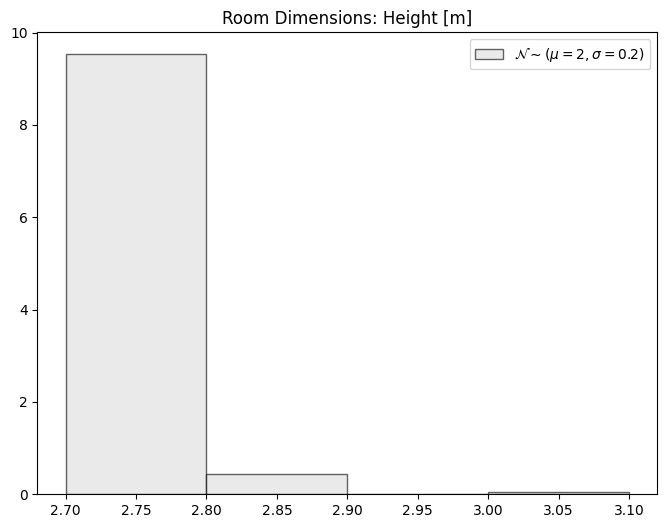

In [32]:
#xdims = result_df["Room Dimensions (x,y,z)"]
xdims = [x[0] for x in result_df['Room Dimensions (x,y,z)']]
ydims = [x[1] for x in result_df['Room Dimensions (x,y,z)']]
zdims = [x[2] for x in result_df['Room Dimensions (x,y,z)']]
plt.figure(figsize=(8,6))
plt.title('Room Dimensions: Length [m]')
plt.hist(xdims,density=True,alpha=0.6,color='#DDDDDD',edgecolor='black',bins=35,label='$\mathcal{N} \sim (\mu=5,\sigma=0.5)$')
plt.legend()
plt.savefig('dimensionx.png',dpi=300)

plt.figure(figsize=(8,6))
plt.title('Room Dimensions: Width [m]')
plt.hist(ydims,density=True,alpha=0.6,color='#DDDDDD',edgecolor='black',bins=33,label='$\mathcal{N} \sim (\mu=5,\sigma=0.5)$')
plt.legend()
plt.savefig('dimensiony.png',dpi=300)

plt.figure(figsize=(8,6))
plt.title('Room Dimensions: Height [m]')
plt.hist(zdims,density=True,alpha=0.6,color='#DDDDDD',edgecolor='black',bins=4,label='$\mathcal{N} \sim (\mu=2,\sigma=0.2)$')
plt.legend()
plt.savefig('dimensionz.png',dpi=300)

In [31]:
import os
import pandas as pd

# Function to extract information from a single .fds file
def extract_fds_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Initialize variables
    chid = None
    tmpa = None
    has_floor_heating = False
    has_radiator = False
    supply_tmp_front = None  # Supply TMP_FRONT
    wall_tmp_front = None    # Wall TMP_FRONT
    room_dimensions = None   # Room dimensions (x, y, z extents)
    vent_type = None         # Vent type (e.g., Swirl, Louvered)
    ##New Variables
    radiator_coords = None #Radiator Coordinates
    inlet_coords = [] #Inlet Coordinates
    exhaust_coords = None #Exhaust Coordinates
    computer_coords = [] #Computer Coordinates
    obstacle_coords = [] #Obstacle Coordinates
    occupant_coords = [] #Occupant Coordinates
    inlet_velocity = None #Inlet Vent Speed

    # Extract CHID and Vent Type from the first line
    if len(lines) > 0:
        first_line = lines[0].strip()
        if "CHID" in first_line:
            chid = first_line.split("CHID =")[1].split("'")[1]
        if "Vent Type:" in first_line:
            try:
                vent_type = first_line.split("Vent Type:")[1].split(",")[0].strip("'")
            except IndexError:
                vent_type = None

    # Extract TMPA from the second line
    if len(lines) > 1:
        second_line = lines[1].strip()
        if "TMPA" in second_line:
            try:
                # Extract TMPA value more flexibly
                tmpa = float(second_line.split("TMPA")[1].split("=")[1].split("/")[0].split(",")[0].strip())
            except (IndexError, ValueError):
                tmpa = None  # Handle cases where TMPA cannot be parsed

    # Check for keywords, Supply TMP_FRONT, Wall TMP_FRONT, and room dimensions in lines
    for line in lines:
        if "floor_heating" in line.lower():
            has_floor_heating = True
        if "radiator" in line.lower():
            has_radiator = True
        if line.strip().startswith("&OBST XB =") and line.strip().__contains__("radiator_top"):
            try:
                radiator_coords = line.split("XB = ")[1].split(", COLOR")[0]
            except (IndexError, ValueError):
                radiator_coords = None
        if line.strip().startswith("&VENT XB=") and line.strip().__contains__("OPEN"):
            try:
                exhaust_coords = line.split("XB=")[1].split(", COLOR")[0]
            except (IndexError, ValueError):
                exhaust_coords = None
        if line.strip().startswith("&SURF ID='supply"):
            # Extract Supply TMP_FRONT value
            try:
                supply_tmp_front = float(line.split("TMP_FRONT=")[1].split("/")[0].strip())
            except (IndexError, ValueError):
                supply_tmp_front = None
        if line.strip().startswith("&SURF ID='supply"):
            # Extract Supply TMP_FRONT value
            try:
                inlet_velocity = float(line.split("VEL=-")[1].split(", VEL_T")[0].strip())
            except (IndexError, ValueError):
                inlet_velocity = float(line.split("VEL=-")[1].split(",TMP_FRONT")[0].strip())
        if line.strip().startswith("&SURF ID='WALL"):
            # Extract Wall TMP_FRONT value
            try:
                wall_tmp_front = float(line.split("TMP_FRONT =")[1].split("/")[0].strip())
            except (IndexError, ValueError):
                wall_tmp_front = None
        if line.strip().startswith("&MESH XB"):
            # Extract room dimensions
            try:
                values = line.split("XB =")[1].split(",")[:6]  # Get the six values after XB =
                room_dimensions = (float(values[1]), float(values[3]), float(values[5]))  # Max x, y, z
            except (IndexError, ValueError):
                room_dimensions = None
        if line.strip().startswith("&OBST XB =") and line.strip().__contains__("INERT"):
            try:
                obstacle_coords.append(line.split("XB = ")[1].split(", COLOR")[0])
            except (IndexError, ValueError):
                obstacle_coords = None
        if line.strip().startswith("&VENT XB=") and line.strip().__contains__("supply"):
            try:
                inlet_coords.append(line.split("XB=")[1].split(", COLOR")[0])
            except (IndexError, ValueError):
                inlet_coords = None
        if line.strip().startswith("&OBST XB =") and line.strip().__contains__("computer"):
            try:
                computer_coords.append(line.split("XB = ")[1].split(", COLOR")[0])
            except (IndexError, ValueError):
                computer_coords = None
        if line.strip().startswith("&OBST XB =") and line.strip().__contains__("occupant"):
            try:
                occupant_coords.append(line.split("XB = ")[1].split(", COLOR")[0])
            except (IndexError, ValueError):
                occupant_coords = None

    return chid, vent_type, tmpa, has_floor_heating, has_radiator, supply_tmp_front, wall_tmp_front, room_dimensions, obstacle_coords, radiator_coords, inlet_coords, exhaust_coords, computer_coords, occupant_coords, inlet_velocity

# Function to classify cases based on TMP_FRONT, Floor Heating, and Radiator
def classify_case(row):
    if row['Supply TMP_FRONT'] == 12:
        return "Cooling"
    elif row['Supply TMP_FRONT'] == 35 or row['Floor Heating'] or row['Radiator']:
        return "Heating"
    else:
        return "Ventilation"

# Function to determine the heating system type
def determine_heating_system(row):
    if row['Case Type'] == "Heating":
        if row['Floor Heating']:
            return "Floor Heating"
        elif row['Radiator']:
            return "Radiator"
        else:
            return "Forced Air"
    return None

# Main script to process all .fds files in a folder (including subfolders)
def process_fds_files(folder_path):
    data = []

    # Walk through the directory and its subdirectories
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith(".fds"):
                file_path = os.path.join(root, file_name)
                chid, vent_type, tmpa, has_floor_heating, has_radiator, supply_tmp_front, wall_tmp_front, room_dimensions, obstacle_coords, radiator_coords, inlet_coords, exhaust_coords, computer_coords, occupant_coords, inlet_velocity = extract_fds_data(file_path)
                # Only add entries with a valid CHID
                if chid is not None:
                    data.append({
                        "CHID": chid,
                        "Vent Type": vent_type,
                        "TMPA": tmpa,
                        "Floor Heating": has_floor_heating,
                        "Radiator": has_radiator,
                        "Supply TMP_FRONT": supply_tmp_front,
                        "Wall TMP_FRONT": wall_tmp_front,
                        "Room Dimensions (x,y,z)": room_dimensions,
                        "Furniture Locations": obstacle_coords,
                        "Radiator Location": radiator_coords,
                        "Supply Vent Locations": inlet_coords,
                        "Exhaust Vent Location": exhaust_coords,
                        "Device Locations": computer_coords,
                        "Occupant Locations": occupant_coords,
                        "Supply Velocity": inlet_velocity
                    })
    
    # Create a DataFrame
    df = pd.DataFrame(data)

    # Add a new column for case classification
    df['Case Type'] = df.apply(classify_case, axis=1)

    # Add a column for Heating System
    df['Heating System'] = df.apply(determine_heating_system, axis=1)

    return df

# Specify the folder containing the .fds files
folder_path = r"out/validation fds"

# Process the files and generate the DataFrame
result_df = process_fds_files(folder_path)

# Display or save the DataFrame
print(result_df)
# Save to CSV if needed
result_df.to_csv("fds_data_summary_with_coords.csv", index=False)


      CHID        Vent Type  TMPA  Floor Heating  Radiator  Supply TMP_FRONT  \
0     1069            Swirl  16.0           True     False              35.0   
1     1855  Louvered Square  25.0           True     False              25.0   
2      797            Swirl  18.0          False      True              18.0   
3     6842  Louvered Square  28.0          False     False              12.0   
4     4729         Louvered  25.0           True     False              25.0   
...    ...              ...   ...            ...       ...               ...   
6995  4336            Swirl  26.0           True     False              26.0   
6996  1644            Swirl  23.0          False     False              23.0   
6997  3113            Swirl  20.0          False      True              20.0   
6998  6461         Louvered  28.0          False     False              12.0   
6999   986            Swirl  19.0          False      True              19.0   

      Wall TMP_FRONT Room Dimensions (x